# PyTorch Threading analysis

On AWS Fargate:

```
ATen/Parallel:
  at::get_num_threads() : 4
  at::get_num_interop_threads() : 8
OpenMP 201511 (a.k.a. OpenMP 4.5)
  omp_get_max_threads() : 4
Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  mkl_get_max_threads() : 4
Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
std::thread::hardware_concurrency() : 8
Environment variables:
  OMP_NUM_THREADS : [not set]
  MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP
```

On a Macbook:

```
ATen/Parallel:
        at::get_num_threads() : 10
        at::get_num_interop_threads() : 10
OpenMP 201811
        omp_get_max_threads() : 10
MKL not found
MKLDNN not found
std::thread::hardware_concurrency() : 10
Environment variables:
        OMP_NUM_THREADS : [not set]
        MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP
```

In [21]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [22]:
matplotlib.rcParams["font.family"] = "serif"

In [4]:
lines = []
with open("runtimes.ndjson") as infile:
    for line in infile:
        line = json.loads(line)
        lines.append(line)

In [5]:
df = pd.DataFrame(lines)
df.shape

(220, 4)

In [6]:
df

,num_interop_threads,num_intraop_threads,mat_size,runtime
0,1,1,1024,0.103191
1,1,1,2048,0.870058
2,1,2,1024,0.106121
3,1,2,2048,0.857515
4,1,4,1024,0.103931
...,...,...,...,...
215,20,14,2048,0.874165
216,20,16,1024,0.097569
217,20,16,2048,0.865995
218,20,18,1024,0.099059


In [7]:
sdf = df[df.mat_size==2048]
sdf.head()

,num_interop_threads,num_intraop_threads,mat_size,runtime
1,1,1,2048,0.870058
3,1,2,2048,0.857515
5,1,4,2048,0.842320
7,1,6,2048,0.841543
9,1,8,2048,0.841394


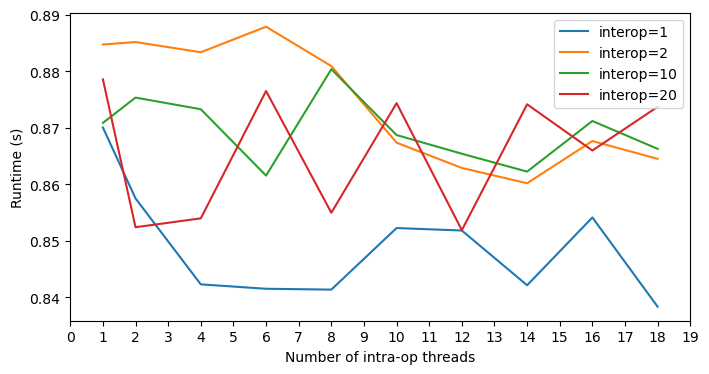

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sdf = df[df.mat_size==2048]

for num_interop_threads in [1, 2, 10, 20]:
    ssdf = sdf[sdf.num_interop_threads == num_interop_threads]
    ax.plot(ssdf.num_intraop_threads, ssdf.runtime, label=f"interop={num_interop_threads}")
    ax.set_xticks(np.arange(0, 20))

ax.legend()
ax.set_xlabel("Number of intra-op threads")
ax.set_ylabel("Runtime (s)")

plt.show()

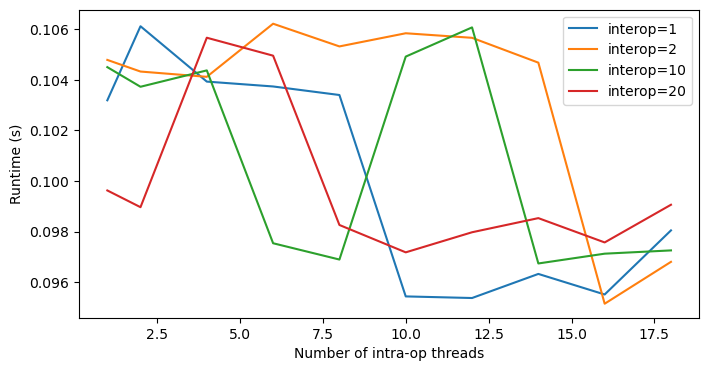

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sdf = df[df.mat_size==1024]

for num_interop_threads in [1, 2, 10, 20]:
    ssdf = sdf[sdf.num_interop_threads == num_interop_threads]
    ax.plot(ssdf.num_intraop_threads, ssdf.runtime, label=f"interop={num_interop_threads}")
    ax.set_xticks(np.arange(0, 20))

ax.legend()
ax.set_xlabel("Number of intra-op threads")
ax.set_ylabel("Runtime (s)")

plt.show()

In [ ]:
m = sdf
nx, ny = z.shape
indx, indy = np.arange(nx), np.arange(ny)
x, y = np.meshgrid(indx, indy)

fig, ax = plt.subplots()
ax.imshow(z.T, interpolation="nearest", cmap=cm.YlGn) # plot grid values

for xval, yval in zip(x.flatten(), y.flatten()):
    zval = z[xval, yval]
    t = "%.1f%%"%(zval * 100,) # format value with 1 decimal point
    c = 'w' if zval > 0.75 else 'k' # if dark-green, change text color to white
    ax.text(xval, yval, t, color=c, va='center', ha='center')

xlabels = 'abcdefghij'
ylabels = '0123456789'
ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
ax.set_yticks(indy+0.5)
ax.grid(ls='-', lw=2)

# the tick labels, if you want them centered need to be adjusted in 
# this special way.
for a, ind, labels in zip((ax.xaxis, ax.yaxis), (indx, indy), 
                          (xlabels, ylabels)):
    a.set_major_formatter(ticker.NullFormatter())
    a.set_minor_locator(ticker.FixedLocator(ind))
    a.set_minor_formatter(ticker.FixedFormatter(labels))

ax.xaxis.tick_top()

plt.show()